In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
%matplotlib notebook

# Input values

In [2]:
cf = 0.01                                       #
ib = 1E-4                                       #1/m
g = 10                                          #m/s^2
L = 10000                                      #m                  #length of space domain
teind = 20 * 24 * 3600                          #sec                #length of time domain

M = 40                                         #[-]                #space resolution
N = 200000                                       #[-]                #time resolution

bump = np.zeros(M)
for i in range (len(bump)):
    if i> 0.4*M and i<0.6*M:
        bump[i] = -1
    else:
        None


d0 = 10 
d = d0 - ib*L/M*np.arange(M) + bump             #m                  # bottom level

u0= - 1                                         #m/s                #flow velocity upstream
Z0 = (cf/g*(u0**2)/ib) + ib*L/M*np.arange(M)    #m                  #Inital waterlevel (eqilibrium depth)

A = 0                                           #meter              #amplitude of tidal wave
w = 1.4E-4                                      #rad/sec            # radial frequentie of tidal wave
ZBC = 20                                        # meter             #mean waterlevel downstream

la = 0.4
k = 1E-5                                                            # m  in engelund hansen
nt = 5


# Analitics

In [3]:
dx = L/M
dt = teind/N
C = np.sqrt(g*np.max(d+Z0))*dt/dx

if C > 1:
    print("Unstable timestep, courrant number is:", C)
elif C > 0:
    print("stable timestep, courrant number is:", C)

de = (cf/g*(u0**2)/ib)
print('The eqilibrium depth is:',round(de),'meters')
print('The halflength of the backwatercurve is:',round(.24*de/ib *(ZBC/de)**(4/3)),'meter')

stable timestep, courrant number is: 0.488752207156
The eqilibrium depth is: 10 meters
The halflength of the backwatercurve is: 60476 meter


# Grid definition

In [4]:
x = np.arange(0,L,dx)
t = np.arange(0,teind,dt)
D = np.zeros((2*N,2*M))

dp = np.zeros((N,M))
S  = np.zeros((N,M))

# Initial conditions

In [5]:
for i in range(round(M)):
    D[0,2*i] = Z0[i]
    D[2,2*i] = Z0[i]
    D[1,1+2*i] = u0
    dp[0,i] = d[i]
    

# Boundary conditions

In [6]:
uUS = u0 * np.ones(N)
ZDS = ZBC+A*np.cos(w*t)

for i in range(round(N)):
    D[2*i,0] = ZDS[i]
    D[1+2*i,2*(M-1)+1]= uUS[i]
#    dp[i,M-1] = d[M-1]

# Numerical simulation

In [7]:
n = 0

for m in range (0,M):
    S[n,m] = k * D[2*n+1,2*m+1] ** nt
    
for m in range (0,M):
    if m<M-1:
        dp[n+1,m] = dp [n,m] - dt/((1-la)*dx)*(S[n,m+1]-S[n,m-1])
    else:
        dp[n+1,m] = dp [n,m] - dt/((1-la)*dx)*(S[n,m]-S[n,m-1])

for n in range(1,round(N-1)):
    for m in range(0,round(M-1)):
        hp = 0.5*(dp[n,m]+dp[n,m+1]+D[2*n,2*m]+D[2*n,2*m+2])
        if D[2*n-1,2*m+1] > 0:
            A = D[2*n-1,2*m+1] *(D[2*n-1,2*m+1]-D[2*n-1,2*m-1])/dx
        else:
            A = D[2*n-1,2*m+1] *(D[2*n-1,2*m+3]-D[2*n-1,2*m+1])/dx
        
        D[2*n+1,2*m+1]=(D[2*n-1,2*m+1] - (dt*g/dx)*(D[2*n,2*m+2]-D[2*n,2*m]) - dt*A)/(1+dt*cf*np.abs(D[2*n-1,2*m+1])/hp) 
    for m in range(1,round(M-1)):
        hp = 0.5*(dp[n,m]+dp[n,m-1]+D[2*n,2*m]+D[2*n,2*m-2])
        hm = 0.5*(dp[n,m]+dp[n,m-1]+D[2*n,2*m]+D[2*n,2*m-2])
        
        D[2*n+2,2*m] = D[2*n,2*m] - (dt/dx)*(hp*D[2*n+1,2*m+1]-hm*D[2*n+1,2*m-1])

    m=M-1
    hp = 0.5*(d[m]+d[m]+D[2*n,2*m]+D[2*n,2*m])
    hm = 0.5*(d[m]+d[m-1]+D[2*n,2*m]+D[2*n,2*m-2])
    
    D[2*n+2,2*m] = D[2*n,2*m] - (dt/dx)*(hp*D[2*n+1,2*m+1]-hm*D[2*n+1,2*m-1])
    
    for m in range (0,M):
        S[n,m] = k * D[2*n+1,2*m+1] ** nt
    
    for m in range (0,M):
        if m<M-1:
            dp[n+1,m] = dp [n,m] - dt/((1-la)*dx)*(S[n,m+1]-S[n,m-1])
        else:
            dp[n+1,m] = dp [n,m] - dt/((1-la)*dx)*(S[n,m]-S[n,m-1])
    
    
    

In [8]:
#np.set_printoptions(precision=2,suppress=False)
#print(dp)

#print(dt,dx)
#np.set_printoptions(precision=1,suppress=True)
#print(D)

# plotting

<IPython.core.display.Javascript object>


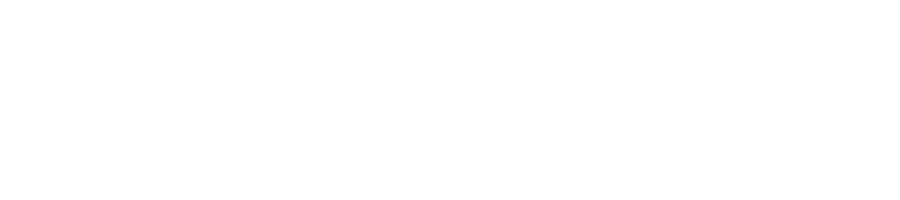

In [9]:
time  = teind*0.8               #sec
T = round(time/dt)

pZ = np.zeros(M)
pu = np.zeros(M)

for m in range(round(M)):
    pZ[m] = D[2*T,2*m]
    pu[m] = D[2*T+1,1+2*m]

    
fig = plt.figure(figsize=(9,2))
plt.plot(x,pZ,x,-d,x,pu,'r');

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
%matplotlib notebook

<IPython.core.display.Javascript object>


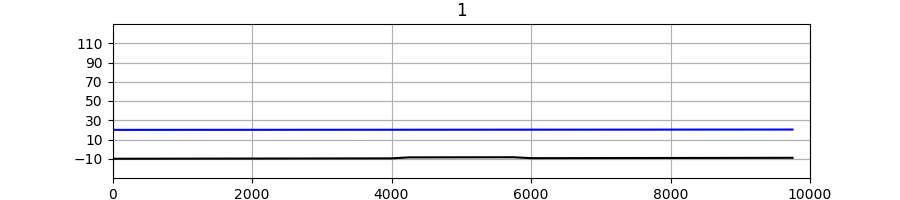

In [20]:
def update_line(i):
    t = i*20
    plt.title(round(t*dt/3600/24))
    for m in range(round(M)):
        pZ[m] = D[2*t,2*m]
    line.set_data([x], [pZ])
    pB = -dp[t,]
    line2.set_data([x], [pB])

fig = plt.figure(figsize=(9,2))
ax = plt.subplot(111, xlim=(0,L), ylim=(-30, 130))
major_ticks = np.arange(-10, 130, 20)
minor_ticks = np.arange(-10, 130, 20)
ax.set_yticks(major_ticks)
ax.set_yticks(minor_ticks, minor=True)

ax.grid(which='both')


line2, = plt.plot([], [], 'k')
line, = plt.plot([], [], 'b')

animation.FuncAnimation(fig, update_line, interval=dt)

<IPython.core.display.Javascript object>


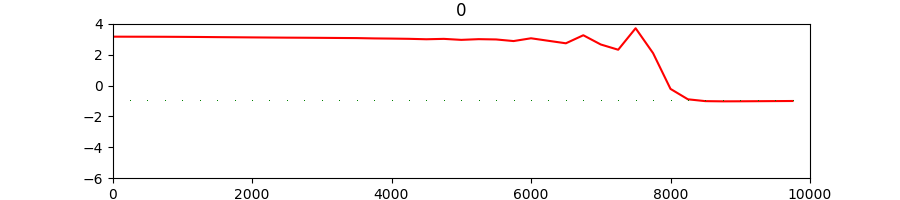

In [22]:
def update_line(i, line):
    t = i*2
    plt.title(round(t*dt/3600))
    for m in range(round(M)):
        pZ[m] = D[2*t+1,1+2*m]
    line.set_data([x], [pZ])

fig = plt.figure(figsize=(9,2))
ax = plt.subplot(111, xlim=(0,L), ylim=(u0-5, u0+5))
line, = plt.plot([], [], 'r')

plt.plot(x,u0*np.ones(len(x)), ',g')
plt.show()

animation.FuncAnimation(fig, update_line, fargs=[line], interval=100)

<IPython.core.display.Javascript object>


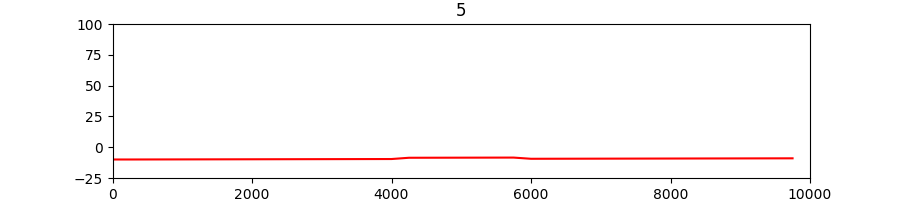

In [21]:
def update_line2(i, line):
    t = i*50
    plt.title(round(t*dt/3600))
    pZ = -dp[t,]
    line2.set_data([x], [pZ])

fig = plt.figure(figsize=(9,2))
ax = plt.subplot(111, xlim=(0,L), ylim=(-25, 100))
line2, = plt.plot([], [], 'r')

animation.FuncAnimation(fig, update_line2, fargs=[line], interval=100)

In [14]:
plt.plot(-dp[0,],'r')
plt.plot(-dp[N-1,],'k')

<IPython.core.display.Javascript object>


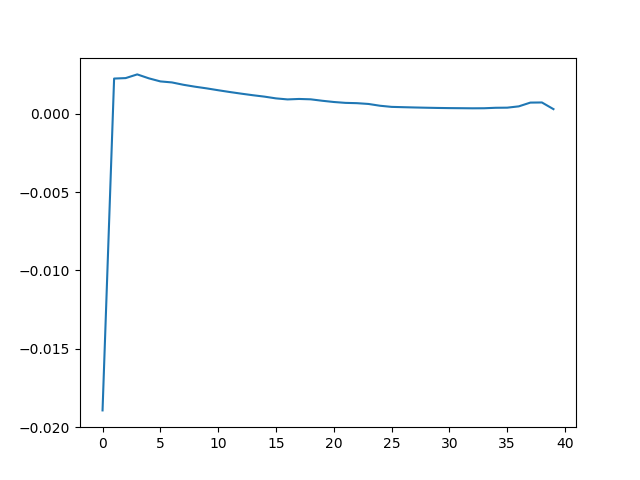

In [23]:
dd = dp[N-1,]-dp[0,]
plt.plot(dd)